In [1]:
# !pip install python-igraph
# !pip install pycairo

In [2]:
import igraph as ig
from igraph import plot
import pandas as pd
import numpy as np
from threading import Timer
from timeit import default_timer as timer
from IPython.display import clear_output
import itertools
import time
import csv

In [3]:
# Python3 program to print Vertex Cover
# of a given undirected graph
from collections import defaultdict


# This class represents a directed graph
# using adjacency list representation
class Graph:

    def __init__(self, dataset, method=None):
        self.cover = []
        # Default dictionary to store graph
        self.graph = defaultdict(list)
        if method is None:
            self.addEdgePear(dataset)
        elif method == 'ma':
            self.addEdgeMA(dataset)
        
        
        # Function to add an edge to graph by adjacency matrix
    def addEdgeMA(self,dataset):      
        for i in np.arange(dataset.shape[1]):
            v = 'v'+str(i+1)   
            l=0
            for j in dataset[v]:
                if(j==1 and i!=l):
                    self.graph[i].append(l)
                l+=1
    # Function to add an edge to graph pear-to-pear          
    def addEdgePear(self, dataset):
        nodes = np.array([dataset.ni,dataset.nj])
        for i in np.arange(len(nodes[0])):
            self.graph[nodes[0][i]].append(nodes[1][i])
        #Exibe o gráfico no formato gráfico
    def graph_plot(self,x_box, y_box, color, layout_type):
        # Instância Graph
        G = ig.Graph()

        # Separando chaves do dicionário
#         print(self.graph)
        graph_keys = list(self.graph.keys())
        # Adicionando n vértices no grafo
        G.add_vertices(len(graph_keys))

        # Encontrando índices das arestas e as adicionando no grafo
        graph_edges = []

        for i, key in enumerate(graph_keys):
            for j in self.graph[key]:
                if j in graph_keys:
                    if not (graph_keys.index(j), i) in graph_edges:
                        graph_edges.append((i, graph_keys.index(j)))

        G.add_edges(graph_edges)

        # Plotagem do grafo
        box = (x_box, y_box)
        layout = G.layout(layout_type) # circle, drl, fr, kk, large, random, rt, rt_circular
        colors = [color] * len(graph_keys)
        return plot(G, layout=layout, bbox = box, vertex_label=graph_keys, vertex_color=colors)
    
    
    
class VerticeCover:
    def __init__(self):
        self.cover = []

    
    
    #function to get sub set deg(V)>k
    def getSubH(self, G, k):
        iso = []
        for u in range(len(G)):
            if(len(G[u])>k):
                iso.append(u)
        return iso
    
    #function get no trivial nodes
    def noTrivial(self, G):
        cont = 0
        for u in range(len(G)):
            if(len(G[u])>=2):
                cont +=1
        return cont
    
    #function to get isolated vertices
    def isolatedsVertices(self, G):
        iso = []
        for u in range(len(G)):
            if(len(G[u])==0):
                iso.append(u)
        return iso
    
    #function to remove some node and its incidences
    def removeNode(self, G, key):
        for i in G:
            if key in G[i]:
                G[i].remove(key)
        iso = self.isolatedsVertices(G)
        for j in iso:
            G.pop(j,None)
        G.pop(key,None)
        return G
    
    #function to remove subset H of G
    def GlessH(self, G, H, k):
        for p in H:
            G = self.removeNode(G, p)
            k = k - len(H)
        isolateds = self.isolatedsVertices(G)
        for i in isolateds:
            G = self.removeNode(G, i)
        return [G,k]
    
    #Buss' algorithm
    def buss(self, G, k):
        isolateds = self.isolatedsVertices(G)
        if(k==0 and len(isolateds)==len(G)):
            return True
        elif(k==0 and len(isolateds)!=len(G)):
            return False
        
        H = self.getSubH(G,k)
        if(len(H)>0):
            if len(H)>k:
                return False
            else:
                G,k2 = self.GlessH(G,H,k)
                if(len(G)>(k*k2)):
                    return False
                return self.buss(G,k2)

            if self.noTrivial(G) > k:
                return False

            for i in isolateds:
                G = self.removeNode(G, i)
            return self.buss(G,k)
        else:
            return self.bruteForce(G, k)
        
   
        
    #function convert proposed cover in sub set graph
    def sugGraph(self, G, nodes):
        H = defaultdict(list)
        for v in nodes:
            H[v] = G[v]
        return H
    
    #function to get edges not repeated
    def getEdge(self, graph):
        edges = set()
        for u in graph:
            for v in graph[u]:
                e = str(u)+str(v)
                if e not in edges and e[::-1] not in edges:
                    edges.add(e)
        return list(edges)
    
    #function to check a valid cover
    def check_cover(self,G, H):
        visited = False*len(G) 
        for i in G:
            if i not in H and i[::-1] not in H:
                return False
        return True
    
    #function to answare by brute force vertice cover
    def bruteForce(self, G,k):
        for i in itertools.combinations(G,k):
            G2 = self.getEdge(G)
            H = self.getEdge(self.sugGraph(G,i))
            if(self.check_cover(G2,H)==True):
                return True
        return False
    

        
    #function to return some valid cover from graph to some k
    def getValidCover(self, G,k):
        for i in itertools.combinations(G,k):
            G2 = self.getEdge(G)
            H = self.getEdge(self.sugGraph(G,i))
            if(self.check_cover(G2,H)==True):
                self.cover = i
                return i
        return 'Não existe cobertura para k='+str(k)

    def timeCount(self, start):
        diff = time.time()-start  
        if(diff<1):
            return str(round(diff*1000,2))+ ' ms'
        else:
            return time.strftime('%H:%M:%S', time.gmtime(diff))
            
    def saveFile(self, results, name='Experiment_results'):
        cols = ['k', 'duration', 'buss_response']
        MyLIst = []
        for x in results:
            MyLIst.append([x,results[x][1],results[x][0]])
            
        df_result= pd.DataFrame(MyLIst, columns = cols)
        print('saving: ',name, '......')
        f = open(name,'a')
        try:
            writer = csv.writer(f)
#             writer.writerow(df_result.columns)
            for i in np.arange(int(df_result.shape[0])):
                writer.writerow(df_result.iloc[i,])
        finally:
            f.close()

    
        
        
    


# Exemplo de Explicação de funcionamento do algoritmo

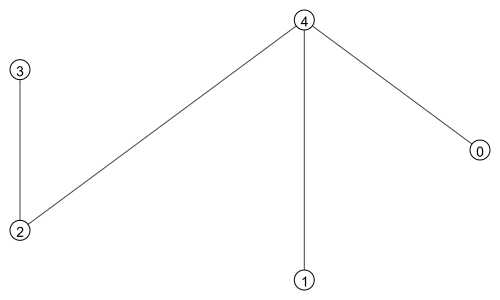

In [4]:
dataset = pd.read_csv('exemples/ex1.csv')
dataset.index = dataset.columns
g = Graph(dataset, 'ma')
g.graph_plot(500, 300, 'white', 'circle')


In [5]:
k=2
vg = VerticeCover()
vg.buss(g.graph,k)


True

In [6]:
g = Graph(dataset, 'ma')

vg = VerticeCover()
vg.getValidCover(g.graph,k)

(2, 4)

# Experimento 1 (Dataset information - Gnutella peer-to-peer network, August 4 2002. Disponível em: https://snap.stanford.edu/data/p2p-Gnutella04.html) 

# Directed graph (each unordered pair of nodes is saved once): 
# p2p-Gnutella04.txt 
# Directed Gnutella P2P network from August 4 2002
# Nodes: 10876 Edges: 39994
# FromNodeId	ToNodeId

In [7]:
dataset2 = pd.read_csv('experiments/exp1.csv')
g = Graph(dataset2)


In [ ]:
# experiments=[1,2,3,4,5,6,7,8,9,10,15,20]
# experiments = [25]
# experiments = [30]
# experiments = [35,40,45]
# experiments = [40,45,50,55,60,70,80,100]


results = defaultdict(list)
for k in range(70,100):
    vg = VerticeCover()
    dataset2 = pd.read_csv('experiments/exp1.csv')
    g = Graph(dataset2)
    print('Analisansdo k=',k,'...')
    start = time.time()    
    results[k].append(vg.buss(g.graph,k))
    results[k].append(vg.timeCount(start))
    
    print('k:',k, 'instance: ',results[k])
    vg.saveFile(results)



Analisansdo k= 70 ...
